# How to query LTHO

In [68]:
import os
import pandas as pd
import sys

src_path = os.path.abspath(os.path.join(os.getcwd(), '..','..'))
sys.path.append(src_path)

from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

# Control LTHO evolution - ROCKET_PNA_UI_ET

In [44]:
QUERY_NAME = 'exposures.sql'
START_DATE = "'2025-01-01'"
END_DATE = "'2025-02-01'"
EXPERIMENT_TOGGLE_ID = "'ROCKET_PNA_UI_ET'"

params = [
    {'name': 'start_date', 'value': START_DATE},
    {'name': 'end_date', 'value': END_DATE},
    {'name': 'experiment_toggle_id', 'value': EXPERIMENT_TOGGLE_ID}
]

q.prepare_query(
    QUERY_NAME, 
    params,
    to_load_file=QUERY_NAME,
    load_from_to_load_file=QUERY_NAME
)

exposures = q.query_run_starburst()

In [45]:
exposures['data__experimentation_variant_value'].unique()

array(['Control Group', 'control_ltho', 'Cart Variant',
       'forced_assignment_1'], dtype=object)

In [47]:
exposures.head()

,p_event_date,data__experimentation_variant_value,customer_count
0,2025-01-01,Control Group,2
1,2025-01-01,control_ltho,1
2,2025-01-02,Cart Variant,1
3,2025-01-02,Control Group,54
4,2025-01-02,forced_assignment_1,1


In [57]:
# Rname _col2 to distinct customers
exposures.rename(columns={'_col2': 'customer_count'}, inplace=True)

# Pivot the table based on the variant value, and count the number of customers in each variant
pivot = exposures.pivot_table(index = 'p_event_date', columns = 'data__experimentation_variant_value', values = 'customer_count', aggfunc = 'sum')
pivot.fillna(0, inplace=True)
pivot.reset_index(inplace=True)
pivot['perc_control_ltho'] = pivot['control_ltho'] / (pivot['Control Group'] + pivot['Cart Variant'] + pivot['control_ltho'] + pivot['forced_assignment_1'])

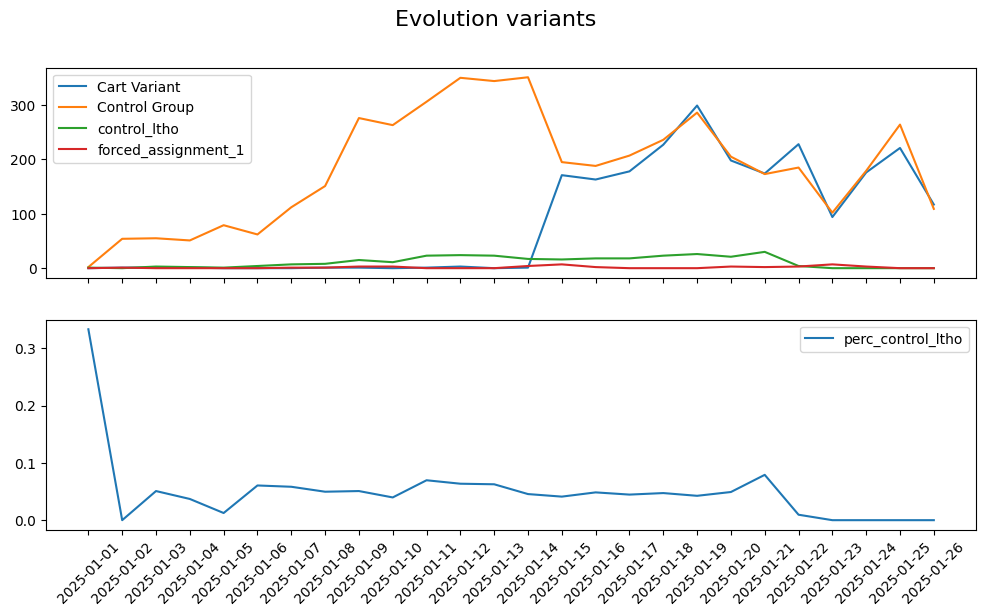

In [58]:
v = dataframe_visualizer.DataFrameVisualizer(pivot)

plot_params = [
    {
        'plot_type': 'lineplot', 
        'x_column': 'p_event_date', 
        'y_columns': ['Cart Variant', 'Control Group', 'control_ltho', 'forced_assignment_1'],
        'legend': True # default True
    },
    {
        'plot_type': 'lineplot', 
        'x_column': 'p_event_date', 
        'y_columns': ['perc_control_ltho'],
        'legend': True # default True
    },
]

figure_params = {
    'n_plots': 2, # default 1
    'fig_length': 12, # default 10
    'fig_height': 6, # default 6
    'x_rotation': 45, # default 45
    'share_x': True, # default False
    'share_y': False, # default False
    'title': 'Evolution variants' # default None
}

# Call the plot method to handle the entire flow
v.plot(
    figure_params=figure_params,
    plot_params=plot_params
)

# Conflicting Customer ids

In [103]:
QUERY_NAME = 'exposures_customer_id.sql'
START_DATE = "'2025-01-24'"
END_DATE = "'2025-01-25'"
EXPERIMENT_TOGGLE_ID = "'ROCKET_PNA_UI_ET'"

params = [
    {'name': 'start_date', 'value': START_DATE},
    {'name': 'end_date', 'value': END_DATE},
    {'name': 'experiment_toggle_id', 'value': EXPERIMENT_TOGGLE_ID}
]

q.prepare_query(
    QUERY_NAME, 
    params,
    to_load_file=QUERY_NAME,
    load_from_to_load_file=None
)

exposures_customer_id = q.query_run_starburst()

/Users/jordicremades/Documents/repos/central-node/src/query_engines.py:138: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(self.tp__read_query, conn)


Open the following URL in browser for the external authentication:
https://starburst.g8s-data-platform-prod.glovoint.com/oauth2/token/initiate/871aa5f74503be75a454d8311a85fb14a8a390e0e74fad815eecf44531d3a447


In [104]:
exposures_customer_id

,p_event_date,data__experimentation_variant_value,data__experimentation_allocation_key
0,2025-01-15,Control Group,10862942


In [105]:
# Aixo es un exemple de un customer que a la taula exposure esta en el Contorl Group, 
# pero que despres no surt a la first_exposure, pots comprobarho amb la taula dabaix.

# select distinct
#     fe.experiment_toggle_id
#     ,fe.allocation_key as customer_id
#     ,fe.variant
#     ,date(fe.first_exposure_datetime) as start_time
# from delta.mlp__experiment_first_exposure__odp.first_exposure fe
# where true
#     --and fe.experiment_toggle_id = 'ROCKET_PNA_UI_ET'
#     and date(fe.first_exposure_datetime) >= date '2025-01-01'
#     and allocation_key = 10862942
# order by 1,2,3,4